## Abnormality Detection in bone X-Rays with CNN
**CNN Conv-Conv-Pool-Conv-Conv-Pool Architecture**

* Katerina Kazantza (p3351801)

In [1]:
import numpy as np
import pandas as pd
import PIL
from tensorflow.keras import layers
from pathlib import Path
import tensorflow as tf
import matplotlib.pyplot as plt
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Input, Convolution2D, MaxPooling2D
from tensorflow.keras.models import Model 
from sklearn.metrics import confusion_matrix, classification_report,roc_curve,auc
from PIL import Image
import cv2
import random

### Data Processing

In [2]:
dataset_root = Path('data/MURA-v1.1')

In [3]:
list(dataset_root.iterdir())

[WindowsPath('data/MURA-v1.1/train'),
 WindowsPath('data/MURA-v1.1/train_image_paths.csv'),
 WindowsPath('data/MURA-v1.1/train_labeled_studies.csv'),
 WindowsPath('data/MURA-v1.1/valid'),
 WindowsPath('data/MURA-v1.1/valid_image_paths.csv'),
 WindowsPath('data/MURA-v1.1/valid_labeled_studies.csv')]

In [4]:
train_imgpaths_df = pd.read_csv(dataset_root/'train_image_paths.csv', header=None, names=['filename'])
train_imgpaths_df.head()

,filename
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...


In [5]:
train_imgpaths_df['class'] = (train_imgpaths_df.filename
               .str.extract('study.*_(positive|negative)'))
train_imgpaths_df.head()

,filename,class
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,positive
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,positive
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,positive
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,positive
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,positive


#### We are sampling half of the training dataset in order to normalize the ImageDataGenerators (This is memory intensive)

In [6]:
x_train = []
y_train = []

for index, row in train_imgpaths_df.iterrows():
    val = random.randint(0,1)
    if val==1:
        image = cv2.imread('data/'+row['filename'])
        image = cv2.resize(image,(224,224))    
        image = image[...,::-1].astype(np.float32)
        x_train.append(image)
        y_train.append(row['class'])

In [7]:
x_train = np.array(x_train).astype('float32') 

In [8]:
x_train.shape

(18508, 224, 224, 3)

#### Data Augmentation
We use Keras’s ImageDataGenerator to perform image augmentation and scale the size of images as 224×224. Then we generate the train and validation dataframes in order to feed the flow_from_dataframe method which have the mapping between filenames of the images and their labels.

In [9]:
def generate_df(dataset_root, csv_name):
    df = pd.read_csv(dataset_root/csv_name, header=None, names=['filename'])
    df['class'] = (df.filename
               .str.extract('study.*_(positive|negative)'))
    return df

In [10]:
datagenerator = ImageDataGenerator(rescale = 1. / 255, validation_split=0.3,featurewise_center=True,
                                   featurewise_std_normalization=True,vertical_flip=False)
datagenerator.fit(x_train)

In [11]:
test_datagenerator = ImageDataGenerator(rescale=1./255,featurewise_center=True, 
                                   featurewise_std_normalization=True)
test_datagenerator.fit(x_train)

In [12]:
train_generator = datagenerator.flow_from_dataframe(generate_df(dataset_root, 'train_image_paths.csv'),
                                        directory=dataset_root.parent,
                                        subset="training",
                                        batch_size=32,
                                        seed=42,
                                        shuffle=True,
                                        target_size=(224, 224),
                                        class_mode='binary')
valid_generator = datagenerator.flow_from_dataframe(generate_df(dataset_root, 'train_image_paths.csv'),
                                        directory=dataset_root.parent,
                                        subset="validation",
                                        batch_size=32,
                                        seed=42,
                                        shuffle=True,
                                        target_size=(224, 224),
                                        class_mode='binary')

Found 25766 validated image filenames belonging to 2 classes.
Found 11042 validated image filenames belonging to 2 classes.


In [13]:

test_generator = test_datagenerator.flow_from_dataframe(generate_df(dataset_root, 'valid_image_paths.csv'),
                                        directory=dataset_root.parent,
                                        batch_size=32,
                                        seed=42,
                                        shuffle=False,
                                        target_size=(224, 224),
                                        class_mode='binary')

Found 3197 validated image filenames belonging to 2 classes.


### Build Model CNN Conv-Conv-Pool-Conv-Conv-Pool
#### Create Model

In [14]:
# in each iteration, we consider 32 training examples at once
batch_size = 32 
# we iterate up to 200 times over the entire training set (depending on the early stopping etc)
num_epochs = 200 
# Convnet Hyper-parameters
# we will use 3x3 kernels (filters) throughout the network
kernel_size_l1 = 3 
kernel_size_l2 = 5 
kernel_size_l3 = 7
kernel_size_l4 = 9 
# we will use 2x2 pooling throughout the network
pool_size = 4 
# # we will initially have 32 kernels per conv. layer...
conv_depth_1 = 128 
# ...switching to 64 after the first pooling layer
conv_depth_2 = 256 
# dropout after pooling with probability 0.25
drop_prob_1 = 0.25 
# dropout in the FC layer with probability 0.5
drop_prob_2 = 0.3
hidden_size = 512 # the FC layer will have 512 neurons
height = 224
width = 224
depth = 3

In [15]:
inp = Input(shape=(height, width, depth))

# set the convolutional layer 1 (conv_1)
conv_1 = Convolution2D(conv_depth_1,  # this is just the instantiation. 
                       (kernel_size_l1, kernel_size_l1),
                       padding='same',
                       activation='relu')

# pass the input layer through the first conv-layer
conv_1 = conv_1(inp)

# set the convolutional layer 2 (conv_2)
conv_2 = Convolution2D(conv_depth_1, # this is NOT just the instantiation. 
                       (kernel_size_l2, kernel_size_l2),
                       padding='same', 
                       activation='relu')(conv_1) # in this line we pass the conv_1 as input to conv_2

# Create a Max Pooling Layer for the 2D filter 
pool_1 = MaxPooling2D(pool_size=(pool_size,
                                 pool_size))(conv_2) # pass here the second conv-layer (conv_2)

# Add a Dropout Layer to reduce overfitting
drop_1 = Dropout(drop_prob_1)(pool_1)

# Create a third conv-layer
conv_3 = Convolution2D(conv_depth_2,
                       (kernel_size_l3, kernel_size_l3),
                       padding='same',
                       activation='relu')(drop_1)

# Create a fourth conv-layer
conv_4 = Convolution2D(conv_depth_2,
                       (kernel_size_l4, kernel_size_l4),
                       padding='same', 
                       activation='relu')(conv_3)

# Again a Max Pooling Layer
pool_2 = MaxPooling2D(pool_size=(pool_size, pool_size))(conv_4)

# Another dropout layer after the max-pooling layer
drop_2 = Dropout(drop_prob_1)(pool_2)

# Flatten the output of the drop_2
flat = Flatten()(drop_2)

# Add a Dense layer
hidden = Dense(hidden_size,activation='relu')(flat)

# Add a Dropout layer
drop_3 = Dropout(drop_prob_2)(hidden)

out = Dense(1,activation='sigmoid')(drop_3)

# create the actual model
model = Model(inputs=inp, outputs=out)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 128)     3584      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 128)     409728    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 56, 56, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 256)       1605888   
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 256)       530867

In [16]:
model.compile(loss=tf.keras.losses.binary_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['acc', 'mse'])

In [17]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
print("STEP_SIZE_TRAIN=",STEP_SIZE_TRAIN,",STEP_SIZE_VALID=",STEP_SIZE_VALID,",STEP_SIZE_TEST=",STEP_SIZE_TEST)

STEP_SIZE_TRAIN= 805 ,STEP_SIZE_VALID= 345 ,STEP_SIZE_TEST= 99


In [18]:
#callbacks for early stopping incase of reduced learning rate, loss unimprovement
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, min_delta=1e-4,restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, verbose=1, min_lr=0.0001)
callbacks_list = [early_stop, reduce_lr]

In [19]:
epochs=200
with tf.device('/device:GPU:0'):
    model_history = model.fit(train_generator,
                        epochs=epochs,
                        workers=0,
                        use_multiprocessing=False,
                        steps_per_epoch = STEP_SIZE_TRAIN,
                        validation_data=valid_generator,
                        validation_steps=STEP_SIZE_VALID,
                        callbacks=callbacks_list
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 805 steps, validate for 345 steps
Epoch 1/200
805/805 [==============================] - 331s 411ms/step - loss: 0.6685 - acc: 0.6582 - mse: 0.2273 - val_loss: 0.7703 - val_acc: 0.4464 - val_mse: 0.2871
Epoch 2/200
805/805 [==============================] - 315s 392ms/step - loss: 0.6432 - acc: 0.6600 - mse: 0.2253 - val_loss: 0.7617 - val_acc: 0.4464 - val_mse: 0.2832
Epoch 3/200
804/805 [============================>.] - ETA: 0s - loss: 0.6421 - acc: 0.6599 - mse: 0.2248
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
805/805 [==============================] - 316s 392ms/step - loss: 0.6420 - acc: 0.6601 - mse: 0.2248 - val_loss: 0.7791 - val_acc: 0.4464 - val_mse: 0.2911
Epoch 4/200
804/805 [============================>.] - ETA: 0s - loss: 0.6418 - acc: 0.6602 - mse: 0.2247
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0001.
805/805 [==============================] - 316s 392ms

#### Saving Model

In [ ]:
model.save("models\\cnnyc\\")

#### Evaluation

In [1]:
from keras.utils import plot_model 
from keras.utils.vis_utils import *
import keras
import importlib
importlib.reload(keras.utils.vis_utils)

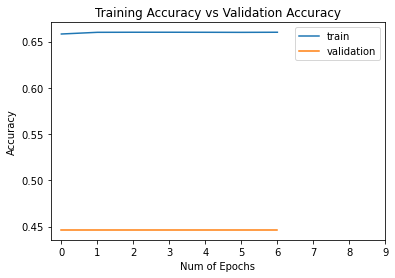

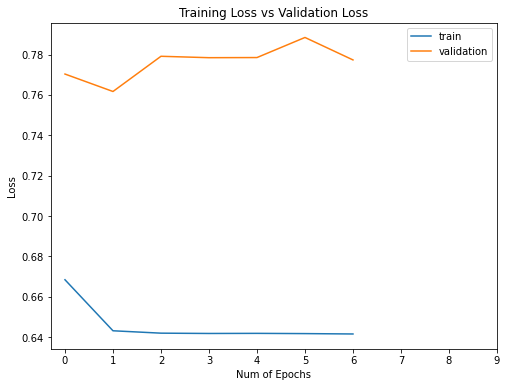

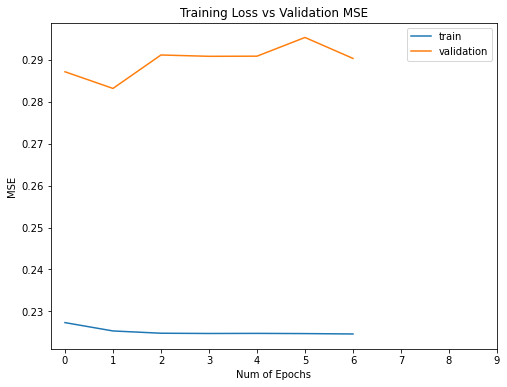

In [21]:
#Now we have trained our model, we can see the metrics during the training proccess
plt.figure(0)
plt.plot(model_history.history['acc'])
plt.plot(model_history.history['val_acc'])
plt.xticks(np.arange(0, 10, 1))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Validation Accuracy")
plt.legend(['train','validation'])
 
plt.figure(1)
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.xticks(np.arange(0, 10, 1))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])

plt.figure(2)
plt.plot(model_history.history['mse'])
plt.plot(model_history.history['val_mse'])
plt.xticks(np.arange(0, 10, 1))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("MSE")
plt.title("Training Loss vs Validation MSE")
plt.legend(['train','validation'])
 
plt.show()

#### Evaluation on test set

In [22]:
ev = model.evaluate_generator(test_generator, steps=STEP_SIZE_TEST,  workers=0, use_multiprocessing=False)
ev[1]

Instructions for updating:
Please use Model.evaluate, which supports generators.
  ...
    to  
  ['...']


0.51704544

In [23]:
test_generator.reset()
predictionsDF = pd.DataFrame(model.predict(test_generator),columns=["predictedProb"])

In [24]:
def extract_patient(string):
    patient = string.split('/')[3]+"/"+string.split('/')[4]
    return patient

def class_binarizer(string):
    if string=="positive":
        return 1
    return 0

def probability_binarizer(prob):
    if prob>=0.5:
        return 1
    return 0

def compareActualVsPred(x):
    if x['predClass']==x['actualClass']:
        return 1
    return 0

def create_test_df_for_predict(valid_imgpaths_df):
    valid_imgpaths_df['patient_study'] = valid_imgpaths_df['filename'].apply(extract_patient)
    valid_imgpaths_df['actualClass'] = valid_imgpaths_df['class'].apply(class_binarizer)
    valid_imgpaths_df['predClass'] = valid_imgpaths_df['predictedProb'].apply(probability_binarizer)
    valid_imgpaths_df['predVsActual']= valid_imgpaths_df.apply(compareActualVsPred, axis=1)
    return valid_imgpaths_df

testDF = generate_df(dataset_root, 'valid_image_paths.csv')
testDF = pd.concat([testDF, predictionsDF], axis=1)
test_df = create_test_df_for_predict(testDF)
test_df

,filename,class,predictedProb,patient_study,actualClass,predClass,predVsActual
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,positive,0.363766,patient11185/study1_positive,1,0,0
1,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,positive,0.363766,patient11185/study1_positive,1,0,0
2,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,positive,0.363765,patient11185/study1_positive,1,0,0
3,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,positive,0.363766,patient11185/study1_positive,1,0,0
4,MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...,positive,0.363763,patient11186/study1_positive,1,0,0
...,...,...,...,...,...,...,...
3192,MURA-v1.1/valid/XR_FINGER/patient11967/study1_...,negative,0.363761,patient11967/study1_negative,0,0,1
3193,MURA-v1.1/valid/XR_FINGER/patient11967/study1_...,negative,0.363761,patient11967/study1_negative,0,0,1
3194,MURA-v1.1/valid/XR_FINGER/patient11738/study1_...,negative,0.363763,patient11738/study1_negative,0,0,1
3195,MURA-v1.1/valid/XR_FINGER/patient11738/study1_...,negative,0.363763,patient11738/study1_negative,0,0,1


In [25]:
print('Classification Report')
print(classification_report(testDF['actualClass'], testDF['predClass'], target_names=["0","1"]))

Classification Report
              precision    recall  f1-score   support

           0       0.52      1.00      0.69      1667
           1       0.00      0.00      0.00      1530

    accuracy                           0.52      3197
   macro avg       0.26      0.50      0.34      3197
weighted avg       0.27      0.52      0.36      3197



c:\users\chark\documents\python\deeplearning_xrays\venv\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Averaging our prediction for each study

In [26]:
df1 = test_df.groupby(['patient_study','actualClass']).agg(
    suma=('predVsActual', 'sum'), counta=('actualClass', 'count'),)
df1 = df1.reset_index()
df1['percentage'] = df1['suma'] / df1['counta']

In [27]:
def majorityBinarizer(x):
    if(x['percentage']>=0.5):
        return x['actualClass']
    else:
        if x['actualClass']==1:
            return 0
    return 1
df1['majorityClass'] = df1.apply(majorityBinarizer, axis=1)

In [28]:
print('Classification Report')
print(classification_report(df1['actualClass'], df1['majorityClass'], target_names=["Negative","Positive"]))

Classification Report
              precision    recall  f1-score   support

    Negative       0.53      1.00      0.70       539
    Positive       0.00      0.00      0.00       469

    accuracy                           0.53      1008
   macro avg       0.27      0.50      0.35      1008
weighted avg       0.29      0.53      0.37      1008



#### Roc & AUC

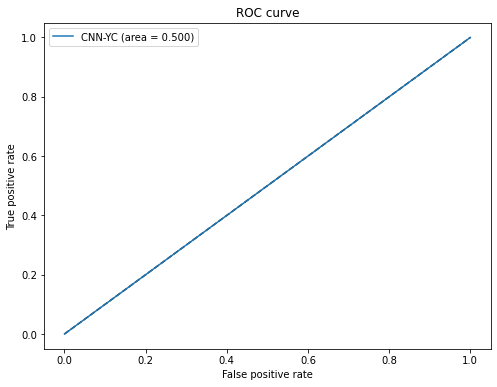

In [29]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(df1['actualClass'], df1['majorityClass'])
auc_keras = auc(fpr_keras, tpr_keras)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='CNN-YC (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()